In [266]:
# Import libraries
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [267]:
# Read in raw data files
df_train = pd.read_csv('./datasets/credit_train.csv')
df_test = pd.read_csv('./datasets/credit_test.csv')

In [268]:
# Concatenate raw data files into one dataframe
df = pd.concat([df_train, df_test])

In [269]:
print("There are", df.shape[0], "before NaN rows removal")

There are 110867 before NaN rows removal


In [270]:
df.isna().sum()/len(df)

Loan ID                         0.007820
Customer ID                     0.007820
Loan Status                     0.098018
Current Loan Amount             0.007820
Term                            0.007820
Credit Score                    0.198454
Annual Income                   0.198454
Years in current job            0.049753
Home Ownership                  0.007820
Purpose                         0.007820
Monthly Debt                    0.007820
Years of Credit History         0.007820
Months since last delinquent    0.535001
Number of Open Accounts         0.007820
Number of Credit Problems       0.007820
Current Credit Balance          0.007820
Maximum Open Credit             0.007838
Bankruptcies                    0.009859
Tax Liens                       0.007919
dtype: float64

In [271]:
# Remove rows which are completely null from dataframe
df = df[df.isnull().sum(axis=1) < df.shape[1]]

In [272]:
print( "There are", df.shape[0], "after NaN rows removed")

There are 110000 after NaN rows removed


 # Deal with incorrect continuous values

In [273]:
df.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,1.100000e+05,88865.000000,8.886500e+04,110000.000000,110000.000000,51553.000000,110000.000000,110000.000000,1.100000e+05,1.099980e+05,109774.000000,109989.000000
mean,1.174621e+07,1076.594644,1.377449e+06,18468.526823,18.202485,34.907086,11.124491,0.168055,2.942822e+05,7.541012e+05,0.117614,0.029448
std,3.176716e+07,1475.581902,1.063920e+06,12195.564391,7.015575,21.965315,5.011093,0.484389,3.772773e+05,8.014002e+06,0.351290,0.261054
min,1.080200e+04,585.000000,7.662700e+04,0.000000,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.795860e+05,705.000000,8.488440e+05,10211.930000,13.500000,16.000000,8.000000,0.000000,1.121950e+05,2.731575e+05,0.000000,0.000000
50%,3.120260e+05,724.000000,1.173459e+06,16202.440000,16.900000,32.000000,10.000000,0.000000,2.096650e+05,4.673900e+05,0.000000,0.000000
75%,5.239300e+05,741.000000,1.651670e+06,23997.522500,21.700000,51.000000,14.000000,0.000000,3.674838e+05,7.831945e+05,0.000000,0.000000
max,1.000000e+08,7510.000000,1.655574e+08,435843.280000,70.500000,176.000000,76.000000,15.000000,3.287897e+07,1.539738e+09,7.000000,15.000000


From the data distribution, maximum credit score is 7510 which is way more than minimum credit score 585，thus the credit score above 850 is requied to be reduced 10X smaller.

In [274]:
# Replace invalid credit scores (above 850 with an extra 0 entered) with credit score 10X smaller
df['Credit Score'] = np.where(df['Credit Score'] > 850, df['Credit Score']/10, df['Credit Score'])

In [275]:
# Drop rows with contaminated credit score (invalid credit score value)
df = df[df['Credit Score'] <= 850]
df = df.reset_index(drop=True)

# Deal with Incorrect categorical values

In [276]:
df.select_dtypes('object').nunique()

Loan ID                 72344
Customer ID             72344
Loan Status                 2
Term                        2
Years in current job       11
Home Ownership              4
Purpose                    16
dtype: int64

In [277]:
#observe meaingful categorical variables values
df[["Home Ownership","Loan Status", "Purpose","Term"]].head(10)

,Home Ownership,Loan Status,Purpose,Term
0,Home Mortgage,Fully Paid,Home Improvements,Short Term
1,Own Home,Fully Paid,Debt Consolidation,Short Term
2,Own Home,Fully Paid,Debt Consolidation,Long Term
3,Home Mortgage,Charged Off,Debt Consolidation,Short Term
4,Home Mortgage,Fully Paid,Debt Consolidation,Short Term
5,Rent,Fully Paid,Debt Consolidation,Short Term
6,Rent,Fully Paid,Debt Consolidation,Short Term
7,Rent,Fully Paid,Debt Consolidation,Short Term
8,Own Home,Fully Paid,Debt Consolidation,Short Term
9,Rent,Fully Paid,Debt Consolidation,Short Term


From the unique values of all meaningful categorical columns, Home Ownership tends to have only 3 types of values as "Home Mortgage", "Own Home" and "Rent", the other one value might be an erroneous value.
There are 16 types of values for "Purpose". Some values within "Purpose" might be redundant can be replaced.

In [278]:
#check Home Ownership
print(df['Home Ownership'].unique())
#'Home Mortgage' and "HaveMortgage" are very similar, the value with fewer counts can be replaced with the value with more counts

['Home Mortgage' 'Own Home' 'Rent' 'HaveMortgage']


In [279]:
df['Home Ownership'].value_counts()

Home Mortgage    42954
Rent             37497
Own Home          8218
HaveMortgage       196
Name: Home Ownership, dtype: int64

The counts of "HaveMortgage" are less than "Homw Mortgage", "HaveMortgage" can be replaced with "Home Mortgage"


In [280]:
df['Home Ownership'] = df['Home Ownership'].replace('HaveMortgage', 'Home Mortgage')
df['Home Ownership'].value_counts()

Home Mortgage    43150
Rent             37497
Own Home          8218
Name: Home Ownership, dtype: int64

In [281]:
#check Purpose
df['Purpose'].value_counts()

Debt Consolidation      69611
other                    5478
Home Improvements        5190
Other                    2888
Business Loan            1412
Buy a Car                1137
Medical Bills            1023
Buy House                 621
Take a Trip               509
major_purchase            325
small_business            260
moving                    135
wedding                    96
Educational Expenses       94
vacation                   77
renewable_energy            9
Name: Purpose, dtype: int64

From the data value description from "Purpose" column, "other" and "Other" are the same, "small_business" will become"business loan" and "take a trip" can be replaced by "vacation". In this case, we can do some merging between values.

In [282]:
df['Purpose'] = df['Purpose'].replace({'small_business':'Business Loan','other':'Other','Take a Trip':'vacation'})
df['Purpose'].value_counts()

Debt Consolidation      69611
Other                    8366
Home Improvements        5190
Business Loan            1672
Buy a Car                1137
Medical Bills            1023
Buy House                 621
vacation                  586
major_purchase            325
moving                    135
wedding                    96
Educational Expenses       94
renewable_energy            9
Name: Purpose, dtype: int64

# Deal with Redundant features

In [283]:
print('The dataset has ', df.shape[0], 'customers')

The dataset has  88865 customers


In [284]:
df.nunique()

Loan ID                         72344
Customer ID                     72344
Loan Status                         2
Current Loan Amount             21046
Term                                2
Credit Score                      167
Annual Income                   37853
Years in current job               11
Home Ownership                      3
Purpose                            13
Monthly Debt                    59476
Years of Credit History           501
Months since last delinquent      109
Number of Open Accounts            51
Number of Credit Problems          14
Current Credit Balance          30994
Maximum Open Credit             41584
Bankruptcies                        8
Tax Liens                          13
dtype: int64

Based on the unique counts for both Loan ID  and Customer ID as 72344, there are customer opens up more than 1 accounts because the total number of customers for the dataset is 88865, but there are only 72344 unique customers. Thus there are redundant records that we need to remove.

In [285]:
#check the duplicate rows
dup_id = df['Customer ID'].value_counts()[df['Customer ID'].value_counts()>1].index.values
dup_df = df.loc[df['Customer ID'].isin(dup_id)]
dup_df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,14dd8831-6af5-400b-83ec-68e61888a048,981165ec-3274-42f5-a3b4-d104041a9ca9,Fully Paid,445412.0,Short Term,709.0,1167493.0,8 years,Home Mortgage,Home Improvements,5214.74,17.2,NaN,6.0,1.0,228190.0,416746.0,1.0,0.0
2,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
11,24e8c8bd-d10b-4dac-8b81-1da470ff5ecb,967e8733-7189-49b7-a3ab-6a1d0e1abdac,Fully Paid,666204.0,Long Term,723.0,1821967.0,10+ years,Home Mortgage,Debt Consolidation,17612.24,22.0,34.0,15.0,0.0,813694.0,2004618.0,0.0,0.0
18,578c8e10-3214-4491-bdbc-b1695ef8ff87,cbe53e22-ba67-4eaf-a4fb-c5acdd12ec66,Fully Paid,465410.0,Long Term,688.0,1722654.0,3 years,Rent,Buy House,15647.45,22.3,30.0,7.0,0.0,107559.0,488356.0,0.0,0.0
19,0c14cb77-29a3-4964-9198-0c43f5f982b0,9baf6d5d-f744-4332-abb0-e939b75cde40,Fully Paid,99999999.0,Short Term,724.0,1029857.0,1 year,Rent,Debt Consolidation,13817.18,12.0,NaN,6.0,0.0,138339.0,221232.0,0.0,0.0


In [286]:
#check number of duplicate values and drop duplicate values
print('There are', dup_df.shape[0], 'duplicate values.')
df = df.drop_duplicates()
print("There are", df.shape[0], "values remaining after dropping duplicates.")

There are 33042 duplicate values.
There are 78650 values remaining after dropping duplicates.


# Deal with missing values

In [287]:
# See how many missing values per column
df.isna().sum()/len(df)

Loan ID                         0.000000
Customer ID                     0.000000
Loan Status                     0.101958
Current Loan Amount             0.000000
Term                            0.000000
Credit Score                    0.000000
Annual Income                   0.000000
Years in current job            0.042390
Home Ownership                  0.000000
Purpose                         0.000000
Monthly Debt                    0.000000
Years of Credit History         0.000000
Months since last delinquent    0.535677
Number of Open Accounts         0.000000
Number of Credit Problems       0.000000
Current Credit Balance          0.000000
Maximum Open Credit             0.000013
Bankruptcies                    0.002123
Tax Liens                       0.000076
dtype: float64

Missing values exist in "Bankruptcies", "Loan Status", "Months since last delinquent", "tax liens", and "years in current job" columns.

Missing values for "bankrupticies", "Months since last delinquent", 'tax liens" should be filled with 0 and missing values for other columns should be filled with mean values.

In [288]:
#fill in missing values with zero and observe distribution 
df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
df['Tax Liens'] = df['Tax Liens'].fillna(0.0)

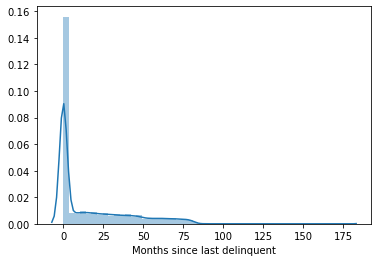

In [289]:
import seaborn as sns
sns.distplot(df['Months since last delinquent'])

In [290]:
#from the plot, we can divdie Months since last delinquent into following categories:
#0: no delinquent, 0~25: 2 years, 25~50: 4 years, 50 ~75: 6 years, >75: over 6 years
df['Delinquent Time'] = 0
df.loc[(df['Months since last delinquent'] == 0), 'Delinquent Time'] = 0
df.loc[(df['Months since last delinquent']>0)&(df['Months since last delinquent']<= 25),'Delinquent Time'] = 2
df.loc[(df['Months since last delinquent']>25)&(df['Months since last delinquent']<= 50),'Delinquent Time'] = 4
df.loc[(df['Months since last delinquent']>50)&(df['Months since last delinquent']<= 75),'Delinquent Time'] = 6
df.loc[(df['Months since last delinquent']>75),'Delinquent Time'] = 6

In [291]:
to_drop = 'Months since last delinquent'
df = df.drop(to_drop, axis = 1)

In [292]:
#exclude bankrupticies, tax linens, and number of credit problems from continuous columns
numeric = df.select_dtypes('number')
numeric_cols = numeric.columns
print(numeric_cols)

Index(['Current Loan Amount', 'Credit Score', 'Annual Income', 'Monthly Debt',
       'Years of Credit History', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens', 'Delinquent Time'],
      dtype='object')


In [293]:
numeric.isna().sum()/len(df)

Current Loan Amount          0.000000
Credit Score                 0.000000
Annual Income                0.000000
Monthly Debt                 0.000000
Years of Credit History      0.000000
Number of Open Accounts      0.000000
Number of Credit Problems    0.000000
Current Credit Balance       0.000000
Maximum Open Credit          0.000013
Bankruptcies                 0.000000
Tax Liens                    0.000000
Delinquent Time              0.000000
dtype: float64

In [294]:
# Impute missing values for numerical data with the mean except bankruptcies and years in current job 
df[numeric.columns] = numeric.fillna(numeric.mean())

In [295]:
#check missing values in categorical columns
categoric = df.select_dtypes('object')
categoric = categoric.drop(columns = 'Years in current job')
print(categoric.columns)

Index(['Loan ID', 'Customer ID', 'Loan Status', 'Term', 'Home Ownership',
       'Purpose'],
      dtype='object')


In [296]:
# Impute missing values for categorical data with the mode
df[categoric.columns] = categoric.fillna(categoric.agg(lambda x: x.mode().values[0]))

In [297]:
#fill NaN for Years in current job with'< 1 year'
df['Years in current job'] = df['Years in current job'].fillna('< 1 year')

In [298]:
#confirm all columns missing values have been filled
df.isna().sum()

Loan ID                      0
Customer ID                  0
Loan Status                  0
Current Loan Amount          0
Term                         0
Credit Score                 0
Annual Income                0
Years in current job         0
Home Ownership               0
Purpose                      0
Monthly Debt                 0
Years of Credit History      0
Number of Open Accounts      0
Number of Credit Problems    0
Current Credit Balance       0
Maximum Open Credit          0
Bankruptcies                 0
Tax Liens                    0
Delinquent Time              0
dtype: int64

# Feature Transformation

For the attributes "Bankruptcies", "Tax Liens", and "Number of Credit Problems", there are differnt unique numer in each attibute. We can categorize these three attibute into two category which are either have had bankruptcy/tax lien/credit probem at least once or never have bankruptcy/tax lien/credit probem before.

In [299]:
df[['Bankruptcies', 'Tax Liens', 'Number of Credit Problems']].nunique()

Bankruptcies                  8
Tax Liens                    13
Number of Credit Problems    14
dtype: int64

We can categorize the attributes "Bankruptcies", "Tax Liens", and "Number of Credit Problems", a customer who have had bankruptcy/tax lien/credit probem at least once is equal to 1, otherwise, the value is equal to 0.

In [300]:
for i in range(len(df)):
    if df['Bankruptcies'].values[i] > 0: 
        df['Bankruptcies'].values[i] = 1
    if df['Tax Liens'].values[i] > 0: 
        df['Tax Liens'].values[i] = 1
    if df['Number of Credit Problems'].values[i] > 0: 
        df['Number of Credit Problems'].values[i] = 1

df[['Bankruptcies', 'Tax Liens', 'Number of Credit Problems']].nunique()

Bankruptcies                 2
Tax Liens                    2
Number of Credit Problems    2
dtype: int64

In [301]:
df.rename(columns= {'Bankruptcies': 'Have had Bankruptcy before'} , inplace=True )
df.rename(columns= {'Tax Liens': 'Have had Tax Liens'} , inplace=True )
df.rename(columns= {'Number of Credit Problems': 'Have had Credit Problems'} , inplace=True )
df.columns

Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Number of Open Accounts', 'Have had Credit Problems',
       'Current Credit Balance', 'Maximum Open Credit',
       'Have had Bankruptcy before', 'Have had Tax Liens', 'Delinquent Time'],
      dtype='object')

In [302]:
# Label encode categorical columns
le = LabelEncoder()
df[categoric.columns] = df[categoric.columns].apply(le.fit_transform)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time
0,5898,43043,1,445412.0,1,709.0,1167493.0,8 years,0,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8 years,1,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4
2,33793,65397,1,347666.0,0,721.0,806949.0,3 years,1,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0
3,39047,22612,0,206602.0,1,729.0,896857.0,10+ years,0,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0
4,11116,40916,1,217646.0,1,730.0,1184194.0,< 1 year,0,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2


In [303]:
# Convert 'Years in current job' to numerical column - 
# Note: Numerical tranformation converts '< 1 year' to 0 and '10+ years' to 10 for simplicity
df['Years in current job'] = df['Years in current job'].replace({'< 1 year':0, '1 year': 1, '2 years': 2,
                                                                 '3 years':3, '4 years':4, '5 years':5, 
                                                                 '6 years':6, '7 years':7, '8 years':8,
                                                                 '9 years': 9, '10+ years': 10})
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time
0,5898,43043,1,445412.0,1,709.0,1167493.0,8,0,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8,1,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4
2,33793,65397,1,347666.0,0,721.0,806949.0,3,1,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0
3,39047,22612,0,206602.0,1,729.0,896857.0,10,0,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0
4,11116,40916,1,217646.0,1,730.0,1184194.0,0,0,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2


# Feature Normalization 

Since we decide to have two types of model: regression model and classification model. Therefore, We separate Credit Score into ten binx and put it into a new column called "Credit Score Range". The bin width for each bin is 16.6. So, we can use the new column "Credit Score Range" as a target for doing classification. 

In [304]:
# Get more insight into 'Credit Score' column
df['Credit Score'].describe()

count    78650.000000
mean       718.380839
std         28.143794
min        585.000000
25%        706.000000
50%        725.000000
75%        740.000000
max        751.000000
Name: Credit Score, dtype: float64

In [305]:
# Add 'Credit Score Range' column
df['Credit Score Range'] = pd.cut(df['Credit Score'], 10)
df.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time,Credit Score Range
0,5898,43043,1,445412.0,1,709.0,1167493.0,8,0,5,5214.74,17.2,6.0,1.0,228190.0,416746.0,1.0,0.0,0,"(701.2, 717.8]"
1,22377,26873,1,99999999.0,1,741.0,2231892.0,8,1,3,29200.53,14.9,18.0,1.0,297996.0,750090.0,0.0,0.0,4,"(734.4, 751.0]"
2,33793,65397,1,347666.0,0,721.0,806949.0,3,1,3,8741.90,12.0,9.0,0.0,256329.0,386958.0,0.0,0.0,0,"(717.8, 734.4]"
3,39047,22612,0,206602.0,1,729.0,896857.0,10,0,3,16367.74,17.3,6.0,0.0,215308.0,272448.0,0.0,0.0,0,"(717.8, 734.4]"
4,11116,40916,1,217646.0,1,730.0,1184194.0,0,0,3,10855.08,19.6,13.0,1.0,122170.0,272052.0,1.0,0.0,2,"(717.8, 734.4]"


In [306]:
names = df.columns

In [307]:
# for i in range(19):
#     print(names[i],"min:", min(df.iloc[:,i]))
#     print(names[i],"max:", max(df.iloc[:,i]), "\n")

Class=(584.834, 601.6], n=223 (0.28%)
Class=(601.6, 618.2], n=426 (0.54%)
Class=(618.2, 634.8], n=696 (0.88%)
Class=(634.8, 651.4], n=1330 (1.69%)
Class=(651.4, 668.0], n=2612 (3.32%)
Class=(668.0, 684.6], n=4157 (5.29%)
Class=(684.6, 701.2], n=7473 (9.50%)
Class=(701.2, 717.8], n=13078 (16.63%)
Class=(717.8, 734.4], n=20290 (25.80%)
Class=(734.4, 751.0], n=28365 (36.06%)


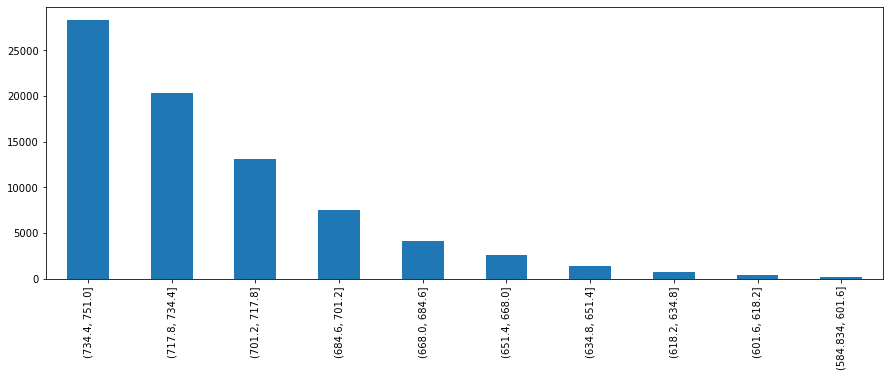

In [308]:
from collections import Counter

counted_target = Counter(df['Credit Score Range'])
for Range, rangeAmount in sorted(counted_target.items()):
    percentage = rangeAmount / len(df['Credit Score Range']) * 100
    print('Class=%s, n=%d (%.2f%%)' % (Range, rangeAmount, percentage))

df['Credit Score Range'].value_counts().plot(kind='bar',figsize=(15,5))

We apply min-max normalization for all the numric attributes.

In [309]:
# Normalize continuous columns
df_tmp = df.drop(columns = ['Purpose'])
numeric = df_tmp.select_dtypes('number')
transformer = preprocessing.MinMaxScaler()
numeric_normalized = transformer.fit_transform(numeric.values)
df[numeric.columns] = numeric_normalized

View the final dataframe after applying min-max normalization.

In [310]:
df.head(10)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time,Credit Score Range
0,0.081528,0.594985,1.0,0.004342,1.0,0.746988,0.006592,0.8,0.0,5,0.011965,0.202096,0.066667,1.0,0.006940,0.000271,1.0,0.0,0.000000,"(701.2, 717.8]"
1,0.309318,0.371466,1.0,1.000000,1.0,0.939759,0.013024,0.8,0.5,3,0.066998,0.167665,0.226667,1.0,0.009063,0.000487,0.0,0.0,0.666667,"(734.4, 751.0]"
2,0.467122,0.903985,1.0,0.003365,0.0,0.819277,0.004413,0.3,0.5,3,0.020057,0.124251,0.106667,0.0,0.007796,0.000251,0.0,0.0,0.000000,"(717.8, 734.4]"
3,0.539748,0.312567,0.0,0.001954,1.0,0.867470,0.004957,1.0,0.0,3,0.037554,0.203593,0.066667,0.0,0.006549,0.000177,0.0,0.0,0.000000,"(717.8, 734.4]"
4,0.153657,0.565583,1.0,0.002064,1.0,0.873494,0.006693,0.0,0.0,3,0.024906,0.238024,0.160000,1.0,0.003716,0.000177,1.0,0.0,0.333333,"(717.8, 734.4]"
5,0.544144,0.686563,1.0,0.005376,1.0,0.560241,0.015002,0.2,1.0,3,0.042814,0.282934,0.040000,0.0,0.013296,0.000360,0.0,0.0,0.666667,"(668.0, 684.6]"
6,0.042962,0.138742,1.0,0.002047,1.0,0.927711,0.008328,0.0,1.0,3,0.090119,0.152695,0.253333,0.0,0.020364,0.000663,0.0,0.0,0.000000,"(734.4, 751.0]"
7,0.198139,0.053855,1.0,1.000000,1.0,0.861446,0.003855,0.3,1.0,3,0.027191,0.184132,0.200000,0.0,0.006204,0.000188,0.0,0.0,1.000000,"(717.8, 734.4]"
8,0.251344,0.067429,1.0,1.000000,1.0,0.933735,0.004227,0.0,0.5,3,0.026565,0.071856,0.066667,0.0,0.004078,0.000143,0.0,0.0,0.333333,"(734.4, 751.0]"
9,0.006981,0.562819,1.0,1.000000,1.0,0.951807,0.008970,0.4,1.0,3,0.040291,0.143713,0.120000,1.0,0.006860,0.000322,1.0,0.0,0.000000,"(734.4, 751.0]"


In [311]:
# Write processed dataframe to csv file called 'credit.csv'
df.to_csv('./datasets/credit.csv', index=False)

In [312]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from matplotlib import pyplot

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [313]:
df.head(10)

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time,Credit Score Range
0,0.081528,0.594985,1.0,0.004342,1.0,0.746988,0.006592,0.8,0.0,5,0.011965,0.202096,0.066667,1.0,0.006940,0.000271,1.0,0.0,0.000000,"(701.2, 717.8]"
1,0.309318,0.371466,1.0,1.000000,1.0,0.939759,0.013024,0.8,0.5,3,0.066998,0.167665,0.226667,1.0,0.009063,0.000487,0.0,0.0,0.666667,"(734.4, 751.0]"
2,0.467122,0.903985,1.0,0.003365,0.0,0.819277,0.004413,0.3,0.5,3,0.020057,0.124251,0.106667,0.0,0.007796,0.000251,0.0,0.0,0.000000,"(717.8, 734.4]"
3,0.539748,0.312567,0.0,0.001954,1.0,0.867470,0.004957,1.0,0.0,3,0.037554,0.203593,0.066667,0.0,0.006549,0.000177,0.0,0.0,0.000000,"(717.8, 734.4]"
4,0.153657,0.565583,1.0,0.002064,1.0,0.873494,0.006693,0.0,0.0,3,0.024906,0.238024,0.160000,1.0,0.003716,0.000177,1.0,0.0,0.333333,"(717.8, 734.4]"
5,0.544144,0.686563,1.0,0.005376,1.0,0.560241,0.015002,0.2,1.0,3,0.042814,0.282934,0.040000,0.0,0.013296,0.000360,0.0,0.0,0.666667,"(668.0, 684.6]"
6,0.042962,0.138742,1.0,0.002047,1.0,0.927711,0.008328,0.0,1.0,3,0.090119,0.152695,0.253333,0.0,0.020364,0.000663,0.0,0.0,0.000000,"(734.4, 751.0]"
7,0.198139,0.053855,1.0,1.000000,1.0,0.861446,0.003855,0.3,1.0,3,0.027191,0.184132,0.200000,0.0,0.006204,0.000188,0.0,0.0,1.000000,"(717.8, 734.4]"
8,0.251344,0.067429,1.0,1.000000,1.0,0.933735,0.004227,0.0,0.5,3,0.026565,0.071856,0.066667,0.0,0.004078,0.000143,0.0,0.0,0.333333,"(734.4, 751.0]"
9,0.006981,0.562819,1.0,1.000000,1.0,0.951807,0.008970,0.4,1.0,3,0.040291,0.143713,0.120000,1.0,0.006860,0.000322,1.0,0.0,0.000000,"(734.4, 751.0]"


In [314]:
X = df.drop(columns = ['Loan ID', 'Customer ID', 'Credit Score Range', 
                       'Credit Score'])

y = df['Credit Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

LR_model = LinearRegression()
LR_model.fit(X,y)

y_pred = LR_model.predict(X_test)
y_pred_train = LR_model.predict(X_train)
## model evaluation
print("MSE for testing set: ", mean_squared_error(y_test, y_pred), "\n")
print("MSE for training set: ", mean_squared_error(y_train, y_pred_train), "\n")
## The best R2 score is 1, it can be negative because the model is arbitrarily worse
print("R2 score for testing set: ", r2_score(y_test, y_pred), "\n")
print("R2 score for training set: ", r2_score(y_train, y_pred_train), "\n")

MSE for testing set:  0.02067894651217036 

MSE for training set:  0.020934385230518788 

R2 score for testing set:  0.2690726187651783 

R2 score for training set:  0.2754894699979471 



In [315]:
X_train.sort_index()

,Loan Status,Current Loan Amount,Term,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time
0,1.0,0.004342,1.0,0.006592,0.8,0.0,5,0.011965,0.202096,0.066667,1.0,0.006940,0.000271,1.0,0.0,0.000000
1,1.0,1.000000,1.0,0.013024,0.8,0.5,3,0.066998,0.167665,0.226667,1.0,0.009063,0.000487,0.0,0.0,0.666667
2,1.0,0.003365,0.0,0.004413,0.3,0.5,3,0.020057,0.124251,0.106667,0.0,0.007796,0.000251,0.0,0.0,0.000000
3,0.0,0.001954,1.0,0.004957,1.0,0.0,3,0.037554,0.203593,0.066667,0.0,0.006549,0.000177,0.0,0.0,0.000000
4,1.0,0.002064,1.0,0.006693,0.0,0.0,3,0.024906,0.238024,0.160000,1.0,0.003716,0.000177,1.0,0.0,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88858,1.0,0.004174,0.0,0.012729,0.6,0.0,3,0.038734,0.275449,0.120000,0.0,0.011715,0.000341,0.0,0.0,0.000000
88860,1.0,0.004314,1.0,0.008776,0.7,0.0,3,0.044728,0.194611,0.133333,0.0,0.012751,0.000427,0.0,0.0,1.000000
88862,1.0,0.001213,1.0,0.004149,0.4,0.0,3,0.028455,0.092814,0.093333,0.0,0.002260,0.000214,0.0,0.0,0.333333
88863,1.0,1.000000,1.0,0.005411,1.0,0.0,3,0.028066,0.196108,0.093333,1.0,0.005626,0.000156,0.0,0.0,0.333333


In [316]:
y_train

30147    0.710843
55320    0.879518
57207    0.843373
19772    0.716867
42676    0.909639
           ...   
49261    0.933735
40778    0.963855
60269    0.614458
4838     0.963855
64008    0.963855
Name: Credit Score, Length: 58987, dtype: float64

In [317]:
dummy_df= pd.read_csv('./datasets/dummy.csv')
dummy_df

,Loan Status,Current Loan Amount,Term,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Have had Credit Problems,Current Credit Balance,Maximum Open Credit,Have had Bankruptcy before,Have had Tax Liens,Delinquent Time
0,1.0,0.004342,1.0,0.006592,0.8,0,5,0.011965,0.202096,0.066667,1.0,0.00694,0.000271,1.0,1.0,0.0


In [318]:
LR_model.predict(dummy_df)

array([0.85375302])

In [319]:
LR_model.predict(dummy_df)*(751-585)+585

array([726.72300164])

training data has 58987 observation with 16 features
test data has 19663 observation with 16 features
Class=0, n=21423 (27.24%)
Class=1, n=21423 (27.24%)
Class=2, n=21423 (27.24%)
Class=3, n=21423 (27.24%)
Class=4, n=21423 (27.24%)
Class=5, n=21423 (27.24%)
Class=6, n=21423 (27.24%)
Class=7, n=21423 (27.24%)
Class=8, n=21423 (27.24%)
Class=9, n=21423 (27.24%)


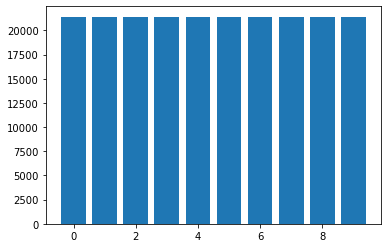

In [411]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[["Credit Score Range"]] = df[["Credit Score Range"]].apply(le.fit_transform)

to_drop = ['Loan ID', 'Customer ID', 'Credit Score Range', 'Credit Score']
X = df.drop(to_drop, axis = 1)
labels = df["Credit Score Range"]

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=1)
print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
counted_target = Counter(y_resampled)
for Range, rangeAmount in sorted(counted_target.items()):
    percentage = rangeAmount / len(df['Credit Score Range']) * 100
    print('Class=%d, n=%d (%.2f%%)' % (Range, rangeAmount, percentage))
pyplot.bar(counted_target.keys(), counted_target.values())
pyplot.show()

In [412]:
clf = LogisticRegression(penalty = 'l2', max_iter=100)
clf.fit(X_resampled, y_resampled)

y_pred_train = clf.predict(X_resampled)
y_pred = clf.predict(X_test)

print('Classification report for training set:\n', classification_report(y_resampled, y_pred_train), '\n')
print('Classification report for testing set:\n', classification_report(y_test, y_pred))

C:\Install\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for training set:
               precision    recall  f1-score   support

           0       0.19      0.50      0.28     21423
           1       0.23      0.32      0.27     21423
           2       0.18      0.27      0.22     21423
           3       0.17      0.07      0.10     21423
           4       0.14      0.00      0.00     21423
           5       0.15      0.00      0.01     21423
           6       0.15      0.02      0.04     21423
           7       0.20      0.20      0.20     21423
           8       0.20      0.14      0.17     21423
           9       0.31      0.68      0.43     21423

    accuracy                           0.22    214230
   macro avg       0.19      0.22      0.17    214230
weighted avg       0.19      0.22      0.17    214230
 

Classification report for testing set:
               precision    recall  f1-score   support

           0       0.01      0.46      0.02        52
           1       0.04      0.35      0.07      

In [413]:
clf.predict(dummy_df)

array([7])